# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Van-Genuchten-Parameters" data-toc-modified-id="Van-Genuchten-Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Van Genuchten Parameters</a></div><div class="lev1 toc-item"><a href="#Van-Genuchen-Equation" data-toc-modified-id="Van-Genuchen-Equation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Van Genuchen Equation</a></div><div class="lev1 toc-item"><a href="#Water-retention-curves" data-toc-modified-id="Water-retention-curves-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Water retention curves</a></div>

Damien Delforge (UCLouvain), 2018

In [2]:
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

# Van Genuchten Parameters

Parameters from CalcPTF - Multimodeling with Pedotransfer Functions: PTF Calculator Manual:

https://www.ars.usda.gov/ARSUserFiles/80420525/EnvironmentalTransport/CalcPTFFiles/PTF_Manual.version_3.0.pdf

With modified alpha for Fine soil: 0.0367 -> 0.00367

In [3]:
table = StringIO("""
Coarse	Medium	Medium fine	Fine	Very fine
theta_r	0.025	0.01	0.01	0.01	0.01
theta_s	0.403	0.439	0.43	0.52	0.614
alpha	0.0383	0.0314	0.0083	0.00367	0.0265
n	1.3774	1.1804	1.2539	1.1012	1.1033
m	0.274	0.1528	0.2025	0.0919	0.0936
""")
params = pd.read_table(table)
params

,Coarse,Medium,Medium fine,Fine,Very fine
theta_r,0.0250,0.0100,0.0100,0.01000,0.0100
theta_s,0.4030,0.4390,0.4300,0.52000,0.6140
alpha,0.0383,0.0314,0.0083,0.00367,0.0265
n,1.3774,1.1804,1.2539,1.10120,1.1033
m,0.2740,0.1528,0.2025,0.09190,0.0936


# Van Genuchen Equation

See below for parameter description.

In [4]:
def thetaVG(h, theta_r, theta_s, alpha, n, m):
    """Van Genuchten equation
    
    The Van Genuchten equation relates the succion
    within the soil matrix to the volumetric water
    content in the soil _[1].
    
    Parameters
    ----------
    h : float
        succion in the soil [cm]
    theta_r : float
        Residual volumetric water content [-]
    tehta_s : float
        Volumetric water content at saturation [-]
    alpha : float
        Air entry value, i.e. matrix succion from which air 
        starts to penetrate into the soil [cm^-1]
    n : float
        Shape parameter [-]
    m : float
        Shape parameter [-]
        
    Return
    ------
    theta : float
        volumetric water content [-]
        
    See also
    --------
    
    _[1] : van Genuchten, M.Th. (1980), doi:10.2136/sssaj1980.03615995004400050002x
        
    """
    num = (theta_s - theta_r)
    den = (1 + (alpha*np.abs(h))**n)**m
    theta = theta_r + num/den
    
    return theta
    

# Water retention curves

These are plot for 3 soil structure: coarse, medium (fine) and fine.

In [5]:
wrc = pd.DataFrame()
wrc['h'] = h_arr = np.logspace(0,7)
for i, col in enumerate(params.columns[[0,2,3]]):
    wrc[col] = wrc['h'].apply(lambda x: thetaVG(x,*(params[col])))
wrc.head()

,h,Coarse,Medium fine,Fine
0,1.000000,0.401850,0.429791,0.519903
1,1.389495,0.401198,0.429685,0.519860
2,1.930698,0.400183,0.429524,0.519799
3,2.682696,0.398612,0.429283,0.519712
4,3.727594,0.396201,0.428920,0.519587


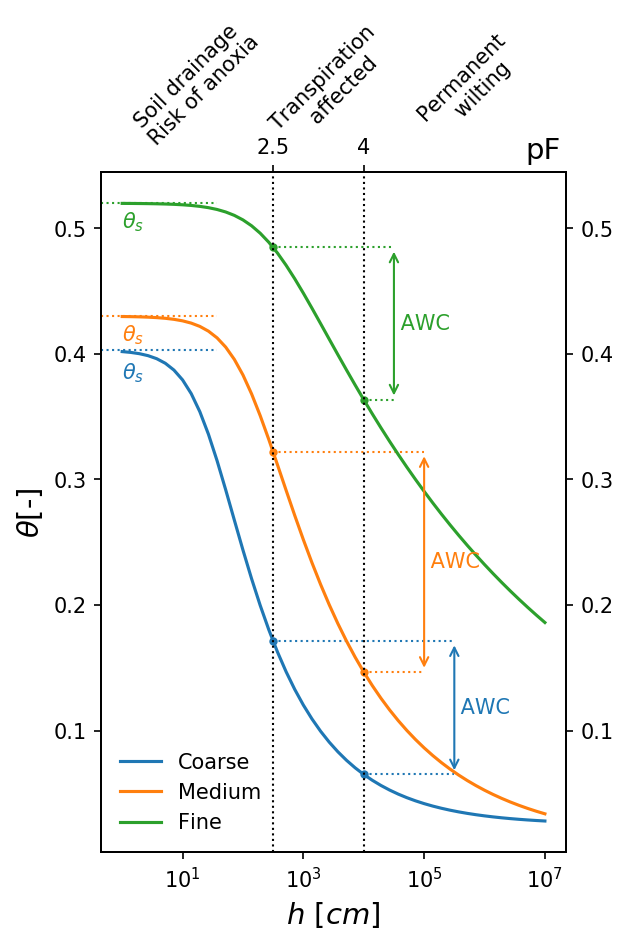

In [6]:
ax = wrc.plot(x='h')
ax.set_xscale('log')
ax.set_ylabel('$\\theta [$-$]$', fontsize=14)
ax.set_xlabel('$ h$ [$cm$]', fontsize=14)
cpal = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, col in enumerate(params.columns[[0,2,3]]):
    ax.axhline(params[col]['theta_s'], xmax=0.25,ls=':', color=cpal[i], lw=1.)
    #ax.axhline(params[col]['theta_r'], ls='-.', color=cpal[i], lw=1.)
    theta_fc = thetaVG(10**2.5, *(params[col]))
    theta_wp = thetaVG(10**4, *(params[col]))
    ax.plot(10**2.5, theta_fc, '.', color=cpal[i])
    ax.plot(10**4, theta_wp, '.', color=cpal[i])


ax.axvline(10**2.5, color='k', ls=':', lw=1)
ax.axvline(10**4, color='k', ls=':', lw=1)

ax.get_figure().set_size_inches(4,6)
ax2 = ax.twinx()
ax3 = ax.twiny()
ax3.set_xscale('log')
ax2.set_ylim(ax.get_ylim())
ax3.set_xlim(ax.get_xlim())
ax3.set_xticks([10**2.5, 10**4])
ax3.set_xticklabels(['2.5', '4'])

ax.text(1,0.38,'$\\theta_s$', color=cpal[0])
ax.text(1,0.41,'$\\theta_s$', color=cpal[1])
ax.text(1,0.5,'$\\theta_s$', color=cpal[2])
ax.text(0.2, 1.13, 'Soil drainage\n Risk of anoxia',
        horizontalalignment='center',
        verticalalignment='center',
        rotation=45,
        transform=ax.transAxes)
ax.text(0.5, 1.13, 'Transpiration \n affected',
        horizontalalignment='center',
        verticalalignment='center',
        rotation=45,
        transform=ax.transAxes)

ax.text(0.8, 1.13, 'Permanent \n wilting',
        horizontalalignment='center',
        verticalalignment='center',
        rotation=45,
        transform=ax.transAxes)

ax3.set_xlabel('pF', fontsize=14)
ax3.xaxis.set_label_coords(0.95, 1.02)

#Arrows for AWC
theta_fc1 = thetaVG(10**2.5, *(params['Coarse']))
theta_fc2 = thetaVG(10**2.5, *(params['Medium fine']))
theta_fc3 = thetaVG(10**2.5, *(params['Fine']))
theta_wp1 = thetaVG(10**4, *(params['Coarse']))
theta_wp2 = thetaVG(10**4, *(params['Medium fine']))
theta_wp3 = thetaVG(10**4, *(params['Fine']))

posx = 10**5.5
ax.hlines(theta_fc1, xmin=10**2.5, xmax=posx, linestyle=':',  lw=1, color=cpal[0])
ax.hlines(theta_wp1, xmin=10**4, xmax=posx,  linestyle=':',lw=1, color=cpal[0])
ax.annotate(s='', xy=(posx,theta_wp1), xytext=(posx,theta_fc1), arrowprops=dict(arrowstyle='<->', linewidth=1, color=cpal[0]))
ax.text(posx, (theta_fc1+theta_wp1)/2, ' AWC', verticalalignment='center', color=cpal[0])

posx = 10**5
ax.hlines(theta_fc2, xmin=10**2.5, xmax=posx, linestyle=':',  lw=1, color=cpal[1])
ax.hlines(theta_wp2, xmin=10**4, xmax=posx,  linestyle=':',lw=1, color=cpal[1])
ax.annotate(s='', xy=(posx,theta_wp2), xytext=(posx,theta_fc2), arrowprops=dict(arrowstyle='<->', linewidth=1, color=cpal[1]))
ax.text(posx, (theta_fc2+theta_wp2)/2, ' AWC', verticalalignment='center', color=cpal[1])

posx = 10**4.5
ax.hlines(theta_fc3, xmin=10**2.5, xmax=posx, linestyle=':',  lw=1, color=cpal[2])
ax.hlines(theta_wp3, xmin=10**4, xmax=posx,  linestyle=':',lw=1, color=cpal[2])
ax.annotate(s='', xy=(posx,theta_wp3), xytext=(posx,theta_fc3), arrowprops=dict(arrowstyle='<->', linewidth=1, color=cpal[2]))
ax.text(posx, (theta_fc3+theta_wp3)/2, ' AWC', verticalalignment='center', color=cpal[2])
ax.legend(['Coarse', 'Medium', 'Fine'], frameon=False, loc='lower left')
